Working through Bishop's chapter on this. Going to go through the analytical derivation of the update rules and then show how it works numerically. Worth noting that this is actually [a practical algorithm][sklearn].

Derivation of update rules
==========================

Basically, I'm copying out a lot of Bishop, trying to fill in where I found it unclear.

Defining the priors
-------------------

Describing the model, we have the conditional distribution of __Z__:

$$ p(\pmb{Z|\pi}) = \prod_{n=1}^{N} \prod_{k=1}^{K} \pi_{k}^{z_{nk}} $$

Conditional distribution of the observed data:

$$ p(\pmb{X|Z, \mu, \Lambda}) = \prod_{n=1}^{N} \prod_{k=1}^{K} \mathcal{N} (x_{n}|\pmb{\mu_{k}, \Lambda_{k}^{-1}})^{z_{nk}} $$

Next, define priors over the parameters. Use a Dirichlet over the mixing coefficients (guess because you know they should be between 0 and 1 in multivariate space:

$$ p(\pi) = Dir(\pmb{\pi|\alpha_{0}}) = C(\pmb{\alpha_{0}}) \prod_{k=1}^{K} \pi_{k}^{\alpha_{0} -1} $$

Where $ C(\pmb{\alpha_{0}}) $ is the normalisation constant for a Dirichlet.

Joint prior Gaussian-Wishart for mean and precision:

$$ p(\pmb{\mu,\Lambda}) = p(\pmb{\mu|\Lambda}) p(\pmb{\Lambda}) $$

Variational Distribution
------------------------

The full joint distribution over the random variables factorizes according to the graphical model:

$$ p(\pmb{X,Z,\pi,\mu,\Lambda}) = p(\pmb{X|Z,\mu,\Lambda}) p(\pmb{Z|\pi}) p(\pmb{\pi}) p(\pmb{\mu|\Lambda} p(\pmb{\Lambda}) $$

$\newcommand{\L}{\pmb{\Lambda}}$
$\newcommand{\Z}{\pmb{Z}}$
$\newcommand{\pib}{\pmb{\pi}}$
$\newcommand{\mub}{\pmb{\mu}}$

Then the variational distribution can be one that factorizes between latent variables and parameters:

$$ q(\Z,\pib,\mub,\L) = q(\Z)q(\pib,\mub,\L) $$

Bishop notes here:

> It is remarkable that this is the _only_ assumption that we need to make in order to obtain a tractable practical solution to our Bayesian mixture model.
> In particular, the functional form of the factors $q(\Z)$ and $q(\Z)q(\pib,\mub,\L)$ will be determined automatically by optimization of the variational distribution.

So to continue we just use apply equation 10.9 (every example is solved like this in Bishop):

$\newcommand{\X}{\pmb{X}}$
$$ \ln q_{j}^{\star} (\Z_{j}) = \mathbb{E}_{i\neq j} \left[ \ln p(\X , \Z) \right] + const. $$

In this case, our factorisation is just between $q(\Z)$ and $q(\pib,\mub,\L)$, so we just end up with:

$$ \ln q^{\star} (\Z) = \mathbb{E}_{\mub,\pib,\L} \left[ \ln p(\X , \Z, \mub, \pib, \L) \right] + const. $$

Looking into that expectation, we have the joint distribution, which we already know how to decompose (above):

$$ \ln q^{\star} (\Z) = \mathbb{E}_{\pib} \left[ \ln p(\Z|\pib) \right] + \mathbb{E}_{\mub,\L} \left[ \ln p(\X | \Z,\pib,\L) \right] + const. $$

Some more things have been absorbed into that constant ($p(\L)$, $p(\mub|\L)$ and $p(\pib)$) because they don't depend on $\Z$.

Then, since we know those conditional distributions, we can just substitute them in:

$$ \ln q^{\star} (\Z) = \mathbb{E}_{\pib} \left[ \ln \prod_{n=1}^{N} \prod_{k=1}^{K} \pi_{k}^{z_{nk}}  \right] + \mathbb{E}_{\mub,\L} \left[ \ln \prod_{n=1}^{N} \prod_{k=1}^{K} \mathcal{N} (x_{n}|\pmb{\mu_{k}, \Lambda_{k}^{-1}})^{z_{nk}}  \right] + const. $$

And then rearrange a bit:

$$ \ln q^{\star} (\Z) = \mathbb{E}_{\pib} \left[  \sum_{n=1}^{N} \sum_{k=1}^{K} z_{nk} \ln \pi_{k}  \right] + \mathbb{E}_{\mub,\L} \left[ \sum_{n=1}^{N} \sum_{k=1}^{K} z_{nk} \ln \mathcal{N} (x_{n}|\pmb{\mu_{k}, \Lambda_{k}^{-1}})  \right] + const. $$

$$ \ln q^{\star} (\Z) =   \sum_{n=1}^{N} \sum_{k=1}^{K}  z_{nk} \mathbb{E}_{\pib} \left[ \ln \pi_{k}  \right] + \sum_{n=1}^{N} \sum_{k=1}^{K} z_{nk} \mathbb{E}_{\mub_{k},\L_{k}} \left[ \ln \mathcal{N} (x_{n}|\pmb{\mu_{k}, \Lambda_{k}^{-1}})  \right] + const. $$

Then we can take everything inside the expectations and define a new variable $\rho_{nk}$:

$$ \ln \rho_{nk} = \mathbb{E}_{\pib} \left[ \ln \pi_{k}  \right] + \mathbb{E}_{\mub_{k},\L_{k}} \left[ \ln \mathcal{N} (x_{n}|\pmb{\mu_{k}, \Lambda_{k}^{-1}})  \right] $$

$ \newcommand{\x}{\pmb{x}} $
$$ \ln \rho_{nk} = \mathbb{E}_{\pib} \left[ \ln \pi_{k}  \right] + \frac{1}{2} \mathbb{E}_{\L_{k}} \left[ \ln |\L_{k}| \right] - \frac{D}{2} \ln(2\pi) - \frac{1}{2} \mathbb{E}_{\mub_{k},\L_{k}} \left[(\x_{k} + \mub_{k})^{T} \L_{k} (\x_{k} + \mub_{k})   \right] $$

Then we can collapse the sums in a nice way and pretend the equation is much simpler than it really is:

$$ \ln q^{\star} (\Z) =   \sum_{n=1}^{N} \sum_{k=1}^{K}  z_{nk} \ln \rho_{nk} + const. $$ 

Now we can take the exponential of both sides:

$$ q^{\star} (\Z) =   \left( \prod_{n=1}^{N} \prod_{k=1}^{K} \rho_{nk}^{z_{nk}} \right) \times const. $$

[sklearn]: http://scikit-learn.org/stable/modules/generated/sklearn.mixture.VBGMM.html#sklearn.mixture.VBGMM

Exercise 10.12
--------------

> Starting from the joint distribution (10.41), and applying the general result (10.9), show that the optimal variational distribution $q^{\star}(\Z)$ over the latent variables for the Bayesian mixture of Gaussians is given by (10.48) by verifying the steps given in the text.

So far we've verified every step above. The final step brings us to:

$$ q^{\star} (\Z) =   \prod_{n=1}^{N} \prod_{k=1}^{K} r_{nk}^{z_{nk}} $$

Where $r_{nk}$ has been defined:

$$ r_{nk} = \frac{\rho_{nk}}{\sum_{j=1}^{K} \rho_{nj} } $$

To get to this answer from before the text advises:

> Requiring that this distribution be normalized, and nothing that for each value of $n$ the quantities $z_{nk}$ are binary and sum to 1 over all values of $k$...

We can go forward by name $const$ from above $c$:

$$ q^{\star} (\Z) =   c \prod_{n=1}^{N} \prod_{k=1}^{K} \rho_{nk}^{z_{nk}} $$

For it to normalise:

$$ 1 =  \sum_{Z} c \prod_{n=1}^{N} \prod_{k=1}^{K} \rho_{nk}^{z_{nk}} $$

I'm willing to admit that I'm not entirely comfortable with this next bit, but it seems to be correct.

Then, since each vector of $\pmb{z}_{n}$ is binary, with a single value being one, at each data point only a single $\rho_{nj}$; if $j$ is where this one is located then the equation becomes:

$$ 1 =  c \prod_{n=1}^{N} \sum_{j=1}^{K} \rho_{nj} $$

Solving for c:

$$ c = \frac{1}{\prod_{n=1}^{N} \sum_{j=1}^{K} \rho_{nj}} $$

Then we can substitute that back into the original equation:

$$ q^{\star} (\Z) = \frac{1}{\prod_{n=1}^{N} \sum_{j=1}^{K} \rho_{nj}} \prod_{n=1}^{N} \prod_{k=1}^{K} \rho_{nk}^{z_{nk}} $$

And rearrange:

$$ q^{\star} (\Z) = \prod_{n=1}^{N} \frac{1}{\sum_{j=1}^{K} \rho_{nj}} \prod_{k=1}^{K} \rho_{nk}^{z_{nk}} $$

As $z_{nk}$ must sum to one over all values of k ($\sum_{k}^{K}z_{nk} = 1$):

$$ q^{\star} (\Z) = \prod_{n=1}^{N} \left(\frac{1}{\sum_{j=1}^{K} \rho_{nj}} \right)^{1} \prod_{k=1}^{K} \rho_{nk}^{z_{nk}} $$

$$ q^{\star} (\Z) = \prod_{n=1}^{N} \left(\frac{1}{\sum_{j=1}^{K} \rho_{nj}} \right)^{\sum_{k=1}^{K}z_{nk}} \prod_{k=1}^{K} \rho_{nk}^{z_{nk}} $$

$$ q^{\star} (\Z) = \prod_{n=1}^{N} \left(\prod_{k=1}^{K} \left(\frac{1}{\sum_{j=1}^{K} \rho_{nj}}\right)^{z_{nk}}\right) \left(\prod_{k=1}^{K} \rho_{nk}^{z_{nk}} \right) $$

$$ q^{\star} (\Z) = \prod_{n=1}^{N}  \prod_{k=1}^{K} \left( \frac{\rho_{nk} }{\sum_{j=1}^{K} \rho_{nj}} \right)^{z_{nk}} $$

Then all we have to do is substitute in $r_{nk}$ as defined above:

$$ q^{\star} (\Z) =   \prod_{n=1}^{N} \prod_{k=1}^{K} r_{nk}^{z_{nk}} $$

And we're done.

Continuing
----------

> Note that the optimal solution for the factor $q(\Z)$ takes the same functional form as the prior $p(\Z|\pi)$.

Finding the expectation of this:

$$ \mathbb{E}_{q^{\star}} [z_{nk}] = \sum_{Z} z_{nk} \prod_{n=1}^{N} \prod_{k=1}^{K} r_{nk}^{z_{nk}} $$

The expectation selects a single element (again, _not_ comfortable with this):

$$ \mathbb{E}_{q^{\star}} [z_{nk}] = r_{nk} $$

Which is actually the expectation of any [categorical distribution][cat].

> At this point, we shall find it convenient to define three statistics of the observed data set evaluated with respect to the responsibilities, given by

$$ N_{k} = \sum_{n=1}^{N} r_{nk} $$

$$ \bar{\x}_{k} = \frac{1}{N_{k}} \sum_{n=1}^{N} r_{nk} \x_{n} $$

$$ \pmb{S}_{k} = \frac{1}{N_{k}} \sum_{n=1}^{N} r_{nk} (\x_{n} - \bar{\x}_k)(\x_{n} - \bar{\x}_{k})^{T} $$

Now we do the same application of equation 10.9 as above, but to the other part of the variational distribution:

$$ \ln q_{j}^{\star} (\Z_{j}) = \mathbb{E}_{i\neq j} \left[ \ln p(\X , \Z) \right] + const. $$

$$ \ln q^{\star} (\pib, \mub, \L) = \mathbb{E}_{\Z} \left[ \ln p(\X , \Z, \mub, \pib, \L) \right] + const. $$

Breaking the joint up into its conditional distributions and substituting yields:

$$ \ln q^{\star} (\pib, \mub, \L) = \ln p(\pib) + \sum_{k=1}^{K} \ln p(\mub_{k}, \L_{k}) + \mathbb{E}_{Z}\left[ \ln p(\Z|\pib) \right] + \sum_{k=1}^{K} \sum_{n=1}^{N} \mathbb{E}[z_{nk}] \ln \mathcal{N} (\x_{n}|\mub_{k}, \L_{k}^{-1}) + const. $$

Observing there are two terms that involve only $\pib$ and the rest contain only $\mub_{k}$ and $\L_{k}$ - and those are a sum of terms. This implies the variational distribution should factorise into:

$$ \ln q^{\star} (\pib, \mub, \L) = q(\pib) \prod_{k=1}^{K} q(\mub_{k}, \L_{k}) $$

Splitting these up into their own equations we have, for $\pib$:

$$ \ln q^{\star}(\pib) = (\alpha_{0} -1) \sum_{k=1}^{K} \ln \pi_{k} + \sum_{k=1}^{K} \sum_{n=1}^{N} r_{nk} \ln_{\pi_{k}} + const. $$

Where $\mathbb{E}[z_{nk}]$ has become $r_{nk}$.

Then, we're supposed to look at that equation and think, "hey! that kind of looks like a [Dirichlet distribution][d] someone's taken the log of!" (alternatively, you could just assume it's going to be Dirichlet because the prior was Dirichlet). Anyway, what we do is take the exponential of it to reveal its inner Dirichlet-ness. However, first, I'm going to substitute in $N_{k}$ and rearrange:

$$ \ln q^{\star}(\pib) =  \sum_{k=1}^{K} (\alpha_{0} -1) \ln \pi_{k} + \sum_{k=1}^{K} N_{k} \ln_{\pi_{k}} + const. $$

$$ \ln q^{\star}(\pib) =  \sum_{k=1}^{K}  \ln \pi_{k}(\alpha_{0} -1 + N_{k}) + const. $$

Then, taking the exponential:

$$  q^{\star}(\pib) =  e^{\sum_{k=1}^{K}  \ln \pi_{k}(\alpha_{0} -1 + N_{k}) + const.} $$

$$  q^{\star}(\pib) =  e^{const.} \prod_{k=1}^{K} e^{ \ln \pi_{k}(\alpha_{0} -1 + N_{k})} $$

$\newcommand{\ab}{\pmb{\alpha}}$
$$ q^{\star}(\pib) =  \frac{1}{B(\ab)} \prod_{k=1}^{K} e^{ \ln \pi_{k}(\alpha_{0} -1 + N_{k})} $$

$$ q^{\star}(\pib) =  \frac{1}{B(\ab)} \prod_{k=1}^{K} \pi_{k}^{\alpha_{0} -1 + N_{k}} = Dir(\pib|\ab) $$

Where $\ab$ has components given by:

$$ \alpha_{k} = \alpha_{0} -1 + N_{k} $$

We can break up the next part of the joint variational distribution using the product rule:

$$ q^{\star} (\mub_{k},\L_{k}) = q^{\star}(\mub_{k}|\L_{k}) q^{\star}(\L_{k}) $$

Expressing these factors in as a Gaussian-Wishart distribution is exercise 10.13.

[cat]: https://en.wikipedia.org/wiki/Categorical_distribution
[d]: https://en.wikipedia.org/wiki/Dirichlet_distribution

Exercise 10.13
--------------

(I started working through this, but I don't have the time. The following is working through the answers, checking the steps used.)

So we get the joint distibution by inspection as above with the $\pib$ component.

$ \newcommand{\N}{\mathcal{N}} $
$ \newcommand{\m}{\pmb{m}} $
$ \newcommand{\W}{\mathcal{W}} $
$ \newcommand{\v}{\mathcal{v}} $
$ \newcommand{\E}{\mathbb{E}} $
$$ \ln q^{\star}(\mub_{k},\L_{k}) = \ln \N \left( \mub_{b}|\m_{0},(\beta_{0}\L_{k})^{-1} \right) + \ln \W (\L_{k}|W_{0}, \v_{0}) + \sum_{n=1}^{N} \E[z_{nk}] \ln \N (\x_{n}| \mub_{k}, \L_{k}^{-1}) \\
= - \frac{\beta_{0}}{2} (\mub_{k} - \m_{0})^{T}\L_{k}(\mub_{k} - \m_{0}) + \frac{1}{2} \ln |\L_{k}| - \frac{1}{2} Tr \left( \L_{k}W_{0}^{-1} \right) + \frac{v_{0} - D -1}{2} \ln |\L_{k}| - \frac{1}{2} \sum_{n=1}^{N} \E [z_{nk}] (\x_{n} - \mub_{k})^{T} \L_{k}(\x_{n} - \mub_{k}) + \frac{1}{2} \left( \sum_{n=1}^{N} \E [z_{nk}] \right) \ln |\L_{k}| + const. $$



Splitting this up as above, by considering only terms that depend on $\mub_{k}$.

$$ \ln q^{\star}(\mub_{k}|\L_{k}) = - \frac{\beta_{0}}{2} (\mub_{k} - \m_{0})^{T}\L_{k}(\mub_{k} - \m_{0}) - \frac{1}{2} \sum_{n=1}^{N} \E [z_{nk}] (\x_{n} - \mub_{k})^{T} \L_{k}(\x_{n} - \mub_{k}) + const. $$

Expanding, rearranging and absorbing more terms into the constant:

$$ \ln q^{\star}(\mub_{k}|\L_{k}) = - \frac{1}{2} \mub_{k}^{T} \left[ \beta_{0} + \sum_{n=1}^{N} \E [z_{nk}]  \right] \L_{k} \mub_{k} + \mub_{k}^{T}\L_{k} \left[ \beta_{0} \m_{0} + \sum_{n=1}^{N} \E[z_{nk}] \x_{n} \right] + const. $$

Substituting in $N_{k}$ and $\bar{\x}_{n}$

$$ \ln q^{\star}(\mub_{k}|\L_{k}) = - \frac{1}{2} \mub_{k}^{T} \left[ \beta_{0} + N_{k}  \right] \L_{k} \mub_{k} + \mub_{k}^{T}\L_{k} \left[ \beta_{0} \m_{0} + N_{k} \bar{\x}_{n} \right] + const. $$

> Thus we see that $\ln q^{\star} (\mub_{k}|\L_{k})$ depends quadratically on $\mub_{k}$ and hence $\ln q^{\star} (\mub_{k}|\L_{k})$ is a Gaussian distribution.

Complete the square for the mean and precision:

$$ \ln q^{\star} (\mub_{k}|\L_{k}) = \N (\mub_{k}| \m_{k}, \beta_{k}\L_{k}) $$

where:

$$ \beta_{k} = \beta_{0} + N_{k} $$

$$ \m_{k} = \frac{1}{\beta_{k}} (\beta_{0}\m_{0} + N_{k} \bar{\x}_{k}) $$

Using the product rule again, we can find $\ln q^{\star} (\L_{k})$:

$$ \ln q^{\star} (\L_{k}) = \ln q^{\star} (\mub_{k}, \L_{k}) - \ln q^{\star} ( \mub_{k}| \L_{k}) $$

We just found the second of these terms, and the first we stated earlier (the massive equation at the start of this exercise):

$$ \ln q^{\star} (\L_{k}) =  - \frac{\beta_{0}}{2} (\mub_{k} - \m_{0})^{T}\L_{k}(\mub_{k} - \m_{0}) + \frac{1}{2} \ln |\L_{k}| - \frac{1}{2} Tr \left( \L_{k}W_{0}^{-1} \right) + \frac{v_{0} - D -1}{2} \ln |\L_{k}| - \frac{1}{2} \sum_{n=1}^{N} \E [z_{nk}] (\x_{n} - \mub_{k})^{T} \L_{k}(\x_{n} - \mub_{k}) + \frac{1}{2} \left( \sum_{n=1}^{N} \E [z_{nk}] \right) \ln |\L_{k}| + \frac{\beta_{k}}{2}(\mub_{k} - \m_{k})\L_{k}(\mub_{k} - \m_{k}) - \frac{1}{2} \ln |\L_{k}| + const. $$

Rearrange this into the shape of Wishart distribution (I am not doing this):

$ \newcommand{\W}{\pmb{W}} $
$$ \ln q^{\star} (\L_{k}) = \frac{(\v_{k} - D - 1)}{2} \ln | \L_{k} | - \frac{1}{2} Tr (\L_{k} \W_{k}^{-1}) + const. $$

Defining $\W_{k}^{-1}$ and $\v_{k}$:

$$ \W_{k}^{-1} = \W_{0}^{-1} + \beta_{0} (\mub_{k} - \m_{0})(\mub_{k} - \m_{0})^{T} + \sum_{n=1}^{N} \E [z_{nk}] (\x_{n} - \mub_{k})(\x_{n} - \mub_{k})^{T} - \beta_{k}(\mub_{k} - \m_{k})(\mub_{k} - \m_{k})^{T} $$

$$ \W_{k}^{-1} = \W_{0}^{-1} + N_{k}\pmb{S}_{k} + \frac{\beta_{0}N_{k}}{\beta_{0} + N_{k}} (\bar{\x}_{k} - \m_{0})(\bar{\x}_{k} - \m_{0})^{T} $$

$$ \v_{k} = \v_{0} + \sum_{n=1}^{N} \E[z_{nk}] \\ = \v_{0} + N_{k} $$

Making use of:

$$ \sum_{n=1}^{N} \E [z_{nk}] \x_{n} \x_{n}^{T} = \sum_{n=1}^{N} \E[z_{nk}] (\x_{n} - \bar{\x}_{k})(\x_{n} - \bar{\x}_{k})^{T} + N_{k}\bar{\x}_{k}\bar{\x}_{k}^{T} \\ = N_{k} \pmb{S}_{k} + N_{k} \bar{\x}_{k}\bar{\x}_{k}^{T} $$

Now we can state the Wishart distribution we've found:

$$ q^{\star}(\L_{k}) = \mathcal{W}(\L_{k}|\W_{k},\v_{k}) $$

Exercise 10.14
--------------

> Using the distribution (10.59)...

$ \newcommand{\q}{q^{\star}} $
$$ \q(\mub_{k},\L_{k}) = \q(\mub_{k}|\L_{k})\q(\L_{k})  \\ = \N \left( \mub_{k}| \m_{k}, (\beta_{k}\L_{k})^{-1} \right) \mathcal{W} (\L_{k}| \W_{k}, \v_{k}) $$

> ...verify the result (10.64):

$$ \E_{\mub_{k},\L_{k}} \left[ (\x_{n} - \mub_{k})^{T} \L_{k} (\x_{n} - \mub_{k}) \right] \\ = D \beta_{k}^{-1} + \v_{k} (\x_{n} - \m_{k})^{T} \W_{k} (\x_{n} - \m_{k}) $$

With a bit of help from Matt Graham got this one figured out; start by expanding what you find in the expectations:

$$ \E_{\mub_{k},\L_{k}} \left[ \x_{n}^{T} \L_{k} \x_{n} - 2\x_{n}^{T} \L_{k} \mub_{k} + \mub_{k}^{T} \L_{k} \mub_{k} \right] $$

Then, we can apply the trace operator to do something a bit weird. As [wikipedia notes][trace] we can express the trace of a product of matrices as the sume of entry-wise products of elements. Luckily, this means we can also do the reverse:

$$ \mub_{k}^{T} \L_{k} \mub_{k} = \sum_{i,j} \mu_{k,i} \Lambda_{k,ij} \mu_{k,j} = \sum_{i} \left( \sum_{j} (\mu_{k,i} \mu_{k,j}) \Lambda_{k,ij} \right) = Tr \left( (\mub_{k} \mub_{k}^{T}) \L_{k} \right) = Tr \left( \L_{k} (\mub_{k} \mub_{k}^{T}) \right) $$

Substituting and moving in the expectation:

$$ \E_{\L_{k}} \left[ \x_{n}^{T} \L_{k} \x_{n} - 2\x_{n}^{T} \L_{k} \E_{\mub_{k}}[\mub_{k}] + Tr \left( \L_{k} \E_{\mub_{k}}[\mub_{k} \mub_{k}^{T}] \right)  \right] $$

Then, we can look at the Normally distributed part of the variational distribution we're using at this point and realise that the expectation of $\mub_{k}$ with respect to this distribution must be equal to its mean, as it's a Normal distribution and its [first moment is equal to its mean][normal]. In other words:

$$ \E_{\mub_{k}}[\mub_{k}] = \m_{k} $$

Then, looking at the expectation inside the trace function and thinking about moments it's obvious that we're looking at the second moment under that normal distribution:

$$ \E_{\mub_{k}}[\mub_{k}\mub_{k}^{T}] = (\beta_{k} \L_{k})^{-1} + m_{k} m_{k}^{T} $$

Then we can just substitute and expand until we're happy with what we've got:

$$ \E_{\L_{k}} \left[ \x_{n}^{T} \L_{k} \x_{n} - 2\x_{n}^{T} \L_{k} \m_{k} + Tr \left( \L_{k} [ (\beta_{k} \L_{k})^{-1} + m_{k} m_{k}^{T} ] \right)  \right] $$

$$ \E_{\L_{k}} \left[ \x_{n}^{T} \L_{k} \x_{n} - 2\x_{n}^{T} \L_{k} \m_{k} + Tr \left( \mathbf{I} \beta_{k}^{-1} + \L_{k} m_{k} m_{k}^{T} ] \right)  \right] $$

Then, we're able to do the same trick from above with the trace operator and bring the two terms outside:

$$ \E_{\L_{k}} \left[ \x_{n}^{T} \L_{k} \x_{n} - 2\x_{n}^{T} \L_{k} \m_{k} + D \beta_{k}^{-1} +  m_{k} \L_{k} m_{k}^{T}  \right] $$

Now, we can see that we can put together one of the terms in the solution we're hoping to get:

$$ \x_{n}^{T} \L_{k} \x_{n} - 2\x_{n}^{T} \L_{k} \m_{k} +  m_{k} \L_{k} m_{k}^{T} = (\x_{n}-\m_{k})^{T}\L_{k}(\x_{n} - \m_{k}) $$

And the other does not depend on $\L_{k}$ so we can just move the expectation in:

$$ (\x_{n}-\m_{k})^{T} \E_{\L_{k}}\left[ \L_{k} \right] (\x_{n} - \m_{k}) + D \beta_{k}^{-1} $$

Which we also know, as the expectation of a [Wishart distribution][wishart] will be it's mean, which is defined as $v_{k} \mathbf{W}_{k}$:

$$ v_{k} (\x_{n}-\m_{k})^{T} \mathbf{W}_{k} (\x_{n} - \m_{k}) + D \beta_{k}^{-1} $$

Which is the answer.

[wishart]: https://en.wikipedia.org/wiki/Wishart_distribution
[trace]: https://en.wikipedia.org/wiki/Trace_(linear_algebra)#Trace_of_a_product
[normal]: https://en.wikipedia.org/wiki/Normal_distribution#Moments

Two more of these expectations gives us:

$$ \ln \tilde{\L}_{k} = \E[\ln |\L_{k}|] = \sum_{i=1}^{N} \psi \left( \frac{\v_{k} +1 -i}{2} \right) + D \ln 2 + \ln | \W_{k} | $$

$$ \ln \tilde{\pi_{k}} = \E[\ln \pi_{k}] = \psi(\alpha_{k}) + \psi(\hat{\alpha}) $$

Where $\psi$ is the digamma function and $\hat{\alpha} = \sum_{k} \alpha_{k}$.

Apparently, now we can just sub in these three equations to the original equation for $\ln \rho_{nk}$

$$ \ln \rho_{nk} = \E [\ln \pi_{k} ] + \frac{1}{2}\E [\ln |\L_{k}|] - \frac{D}{2} \ln (2\pi) - \frac{1}{2} \E_{\mub_{k},\L_{k}} \left[ (\x_{n} - \mub_{k})^{T} \L_{k} (\x_{n} - \mub_{k}) \right] $$

But, don't sub _too much_:

$$ \ln \rho_{nk} = \ln \tilde{\pi}_{k} + \frac{1}{2} \ln \tilde{\L} - \frac{D}{2} \ln (2\pi) - \frac{1}{2} \left( D \beta_{k}^{-1} + \v_{k} (\x_{n} - \m_{k})^{T} \W_{k} (\x_{n} - \m_{k}  \right) $$

Then take the exponential:

$$ \rho_{nk} = \tilde{\pi}_{k} \tilde{\L}^{\frac{1}{2}} (2\pi)^{- \frac{D}{2}} \exp \left(-\frac{D}{2} \beta_{k}^{-1} - \frac{\v_{k}}{2} (\x_{n} - \m_{k})^{T} \W_{k} (\x_{n} - \m_{k} ) \right) $$

Then we can easily calculate $r_{nk}$ with:

$$ r_{nk} = \frac{\rho_{nk}}{\sum_{j=1}^{K} \rho_{nj}} $$

So, finally, we can learn the variational distribution of our model from the data by iteratively updating $r_{nk}$, fixing these responsibilities and updating the variational distributions from their definitions above. Then we just calculate $r_{nk}$ again and keep going round til we're satisfied.

Time for the numerical example, but Bishop provides no code so we're going to have to make our own.

Numerical Example
=================

We're going to be working with the old faithful data, so first we'd better make sure we have that:

In [1]:
!wget http://www.stat.cmu.edu/~larry/all-of-statistics/=data/faithful.dat

--2016-01-24 12:25:39--  http://www.stat.cmu.edu/~larry/all-of-statistics/=data/faithful.dat
Resolving www.stat.cmu.edu (www.stat.cmu.edu)... 128.2.12.64
Connecting to www.stat.cmu.edu (www.stat.cmu.edu)|128.2.12.64|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6608 (6.5K) [text/plain]
Saving to: ‘faithful.dat’

faithful.dat        100%[=====================>]   6.45K  --.-KB/s   in 0s     

2016-01-24 12:25:39 (1014 MB/s) - ‘faithful.dat’ saved [6608/6608]



Unfortunately, they've shoved a massive header into the file for some reason:

In [2]:
!head -n 30 faithful.dat

Old Faithful Geyser Data

Description: (From R manual):

     Waiting time between eruptions and the duration of the eruption
     for the Old Faithful geyser in Yellowstone National Park, Wyoming,
     USA.

     A data frame with 272 observations on 2 variables.

eruptions  numeric  Eruption time in mins
waiting    numeric  Waiting time to next eruption

References:

     Hardle, W. (1991) Smoothing Techniques with Implementation in S.
     New York: Springer.

     Azzalini, A. and Bowman, A. W. (1990). A look at some data on the
     Old Faithful geyser. Applied Statistics 39, 357-365.





    eruptions waiting
1       3.600      79
2       1.800      54
3       3.333      74
4       2.283      62


We have to cut that part off before we have a useful csv:

In [3]:
!tail -n+26 faithful.dat > faithful.csv

Then we can just use numpy to load the data into an array:

In [12]:
import numpy as np
from scipy.special import psi as digamma

Skipping the first row because it's just labels.

In [5]:
data = np.loadtxt("faithful.csv",skiprows=1)

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

/home/gavin/venvs/value/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/gavin/venvs/value/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


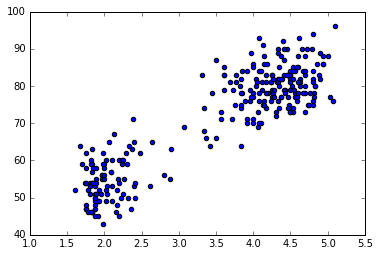

In [7]:
plt.scatter(data[:,1],data[:,2])

Creating a Variational Mixture of Gaussians model
-------------------------------------------------

To define the model we first need to store the parameters of the model as described above. These are the parameters of the prior distributions: $\alpha_{0}$, $\m_{0}$, $\W_{0}$ and $\v_{0}$.

Choosing default values for these is a little tricky. Going for 1 for the alpha array, hoping that's not too strong. $\m_{0}$ is a bit easier:

> Typically we would choose $\m_{0} = 0$ by symmetry.

$\W_{0}$ is hard. It's our prior belief about the covariance matrix of the distributions. I guess a good prior would be that the covariance matrix is diagonal. What does that require the Wishart matrix to be then?

[Wikipedia][wishart] might be able to help. It suggests that you just multiply your guess for the covariance matrix by the other parameter of the Wishart. Will just make a string option to implement this.

[wishart]: https://en.wikipedia.org/wiki/Wishart_distribution

In [13]:
# initialise prior parameters
k = 2
alpha_0 = 1.
m_0 = np.zeros(k)
# just making the Wishart covariance diagonal as well
v_0 = 1.
W_0 = np.eye(k)*v_0
beta_0 = 1.
D = 2

In [14]:
# initialise variational update functions

##########
# M step #
##########
def _lnrho_nk(E_lnpi_k, E_lnLambda_k, D, E_mu_k_Lambda_k):
    return E_lnpi_k + 0.5*E_lnLambda_k - (D/2.)*np.log(2.0*np.pi) - 0.5*E_mu_k_Lambda_k

def _r_k(rho_k):
    return rho_k/np.sum(rho_k, axis=1)

def _N_k(r_k):
    return np.sum(r_k)

def _x_bar_k(N_k, r_k, X):
    return (1./N_k)*np.dot(X,r_k)

def _S_k(N_k, r_k, x_bar_k):
    return (1./N_k)*np.dot(np.dot((X-x_bar_k.T).T, X-x_bar_k.T),r_k)

def _alpha(alpha_0, N):
    return alpha_0 + N

def _beta(beta_0, N):
    return beta_0 + N

def _m_k(beta_0, beta_k, m_0, N_k, x_bar_k):
    return (1./beta_k)*(beta_0*m_0 + N_k*x_bar_k)

def _invW_k(W_0, N_k, S_k, beta_0, x_bar_k, m_0):
    return np.linalg.inv(W_0) + N_k*S_k + \
           ((beta_0*N_k)/(beta_0 + N_k))*np.dot(x_bar_k-m_0, (x_bar_k - m_0).T)

def _v_k(v_0, N_k):
    return v_0 + N_k

##########
# E Step #
########## 
def _alpha_hat(alpha):
    return np.sum(alpha)

def _E_lnpi_k(alpha_k, alpha_hat):
    return digamma(alpha_k) - digamma(alpha_hat)

def _E_lnLambda_k(W_k, v_k, D):
    D_its = np.zeros(D)
    for i in range(D):
        D_its[i] = digamma((v_k+1-i)/(2.)) + D*np.log(2) + np.log(np.linalg.det(W_k))
    return np.sum(D_its)
        
def _E_mu_k_Lambda_k(X, beta_k, v_k, m_k, W_k):
    return D*beta_k**-1 + v_k*np.dot(np.dot((X-m_k.T), W_k), (X-m_k.T).T)

# Confused yet?

In [ ]:
# r_k MUST BE A COLUMN VECTOR
# assuming rho is a big matrix with n indexing rows and k indexing columns

In [20]:
# we need to be able to visualise the distribution we've learnt to have
# any idea if it's working
def normal_density(x, mu, Sigma):
    return (1./np.sqrt(2.*np.pi*np.linalg.det(Sigma)))\
            *np.exp(-0.5*np.dot(np.dot((x-mu).T, np.linalg.inv(Sigma)),(x-mu)))

from scipy.special import multigammaln
def wishart_density(X, n, V):
    p = X.shape[0]
    assert X.shape[1] == p
    normalising = (2.0**(n*p/2.0))*np.power(np.linalg.det(V), n/2.)
    return (np.power(np.det(X), (n-p-1)/2)*\
            np.exp(-0.5*np.trace(np.dot(np.linalg.inv(V), X))))/normalising
    
def get_p_mu_k(m_0, beta_0, Lambda_k):
    return lambda mu: normal_density(mu, m_0, np.linalg.inv(beta_0*Lambda_k))

# PENDING: Dirichlet and complete density of mixture...